In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from math import sin, cos, atan2, pi
from scipy.linalg import expm, sinm, cosm
from scipy.stats import norm

In [6]:
N = 1000 #Number of samples
pdL = 1.5 #phi_dot_L = LEFT commanded wheel speed
pdR = 2 #phi_dot_R = RIGHT commanded wheel speed
r = 0.25 #Radius of each wheel
w = 0.5 #Distance between left and right wheel
stdL = 0.05 #standard deviation lEFT wheel speed
stdR = 0.05 #standard deviation RIGHT wheel speed
stdP = 0.1  #standard deviation measurement error

In [7]:
def dataFROMpose(X):
    #create x data and y data
    x_data=[]
    y_data=[]
    
    for i in range (N):
        x_data.append(X[i][0][2])
        y_data.append(X[i][1][2])
    
    return x_data,y_data

In [8]:
def stats(x_data,y_data,N):
    
    ### MEAN/Centroid of the set
    x_cen=sum(x_data)/N
    y_cen=sum(y_data)/N

    ###Covariance
    #list created after subtracting mean
    x_centered  = [x - x_cen for x in x_data]
    y_centered  = [y - y_cen for y in y_data]
    # multiply the list created after subtracting mean ELEMENTWISE
    xy_multiplied_list = [x_centered[i] * y_centered[i] for i in range(len(x_centered))]
    
    #square each centered element of the list
    x_cs = [x_centered[i]**2 for i in range(len(x_centered))]
    y_cs = [y_centered[i]**2 for i in range(len(y_centered))]

    COV=sum(xy_multiplied_list)/(N)
    COVx = sum(x_cs)/N
    COVy = sum(y_cs)/N
    
    mean = (x_cen,y_cen)
    cov = np.array([[COVx],[COVy]])
    return mean,cov

In [9]:
#Function that adds noise to the LEFT and RIGHT wheel speeds
def add_sample():
    #Get True wheel speeds by adding noise
    phi_L = pdL + np.random.normal(0,stdL)
    phi_R = pdR + np.random.normal(0,stdR)
    return phi_L,phi_R

In [10]:
def find_pose(t1,X_t1,t2):
    vl = pdL + np.random.normal(0,stdL)
    vr = pdR + np.random.normal(0,stdR)

    V=np.array([[(r/2)*(vr+vl)],[0],[(r/w)*(vr-vl)]])

    omega = np.array([[0,-V[2][0],V[0][0]],[V[2][0],0,0],[0,0,0]])

    X_t2 = X_t1 @ expm((t2-t1)*omega)
    
    return X_t2

In [11]:
def particle_filter_propagate(t1,X_T1,t2,N):
    X_T2=[]
    for i in range(N):
        if len(X_T1)>10:
            X_2pose = find_pose(t1,X_T1[i],t2)
        else:
            X_2pose = find_pose(t1,X_T1,t2)
        X_T2.append(X_2pose)
    return X_T2

In [12]:
def CalculateImportanceWeights(X,z):
    weights=[]
    distance = []
    
    XX = np.array(X)
    translation = XX.T[2]
    
    #Samples weights using the distance error of each particle from the provided measurement zt
    for i in range (N):
        x,y = translation[0:2,i]
        dis = np.linalg.norm(z-np.array([[x],[y]]))
        w = norm.pdf(dis, loc=0, scale=stdP)
        distance.append(dis)
        weights.append(w)
        
    #convert list to numpy array
    wnp=np.array(weights)
    weight_nparr=np.reshape(wnp,(1,N))
    
    return weight_nparr


def calculate_importance_weights(X, z):
    weights = []
    distances = []

    particle_array = np.array(X)
    translations = particle_array.T[2]

    for i in range(N):
        x, y = translations[0:2, i]
        distance = np.linalg.norm(z - np.array([[x], [y]]))
        weight = norm.pdf(distance, loc=0, scale=stdP)
        distances.append(distance)
        weights.append(weight)

    weight_array = np.array(weights)
    weight_nparr = np.reshape(weight_array, (1, N))

    return weight_nparr

In [13]:
def particle_filter_update(X_list,z):
    X_array = np.array(X_list)

    weights = calculate_importance_weights(X_list,z)

    weights /= np.sum(weights)
    pos = (np.arange(N) + np.random.random())/ N

    indices = np.searchsorted(np.cumsum(weights),pos)
    
    X_array[:] = X_array[indices]
    
    return X_array

For t = 10secs:
MEAN: (1.061584872428726, 3.0775625479197135) 
COVARIANCE:  [[0.38380303 0.02056642]]


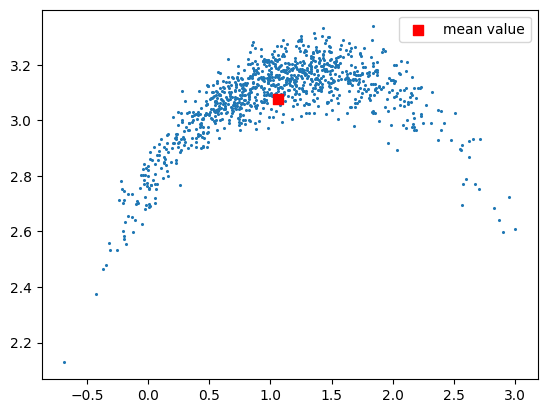

In [14]:
################# PART E ###########################################

####################################################################

X0=np.eye(3)

#Particle PROPAGATION
X10=ParticleFilterPropagate(0,X0,10,N)

#Create x data and y data
x_data,y_data=dataFROMpose(X10)

#Mean and Covariance
mean, COV = stats(x_data,y_data,N)
x_cen, y_cen = mean

#plot the position of particle
fig = plt.figure()
f1=plt.scatter(x_data,y_data,s=1.5)
f2=plt.scatter(x_cen,y_cen,s=50,marker='s',color = 'r')
plt.legend([f2], ['mean value'],markerscale=1)

print("For t = 10secs:\nMEAN:",mean,"\nCOVARIANCE: ",COV.T)

For t = 5secs:
MEAN: (1.6513122618574525, 1.1930604481284413) 
COVARIANCE:  [[0.01941495 0.01587914]]


For t = 10secs:
MEAN: (1.044404030698993, 3.1050846647914354) 
COVARIANCE:  [[0.25533306 0.01467212]]


For t = 15secs:
MEAN: (-0.9265079522413509, 3.1317101153746627) 
COVARIANCE:  [[0.29559717 0.34588339]]


For t = 20secs:
MEAN: (-1.5689541537474871, 1.3012992809320176) 
COVARIANCE:  [[0.25439676 0.62137502]]


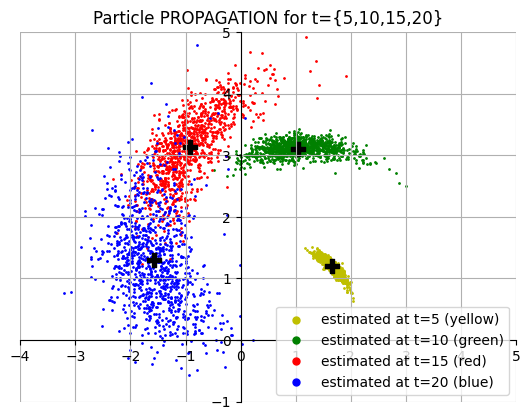

In [15]:
############################################### PART F ####################################################

###########################################################################################################
t1 = 0
t2 = 5
t3 = 10
t4 = 15
t5 = 20

#initial particle set X0 consisting of N = 1000 copies of I = (0, I2) ∈ SE(2)
X0=ParticleFilterPropagate(0,np.eye(3),t1,N)

##################### Propagation from t1 = 0 to t2 = 5 ####################################
X5=ParticleFilterPropagate(t1,X0,t2,N)

#create x data and y data
x5_data,y5_data=dataFROMpose(X5)

#Mean and Covariance
mean5, COV5 = stats(x5_data,y5_data,N)
x5_cen, y5_cen = mean5



##################### Propagation from t2 = 5 to t3 = 10 ####################################
X10=ParticleFilterPropagate(t2,X5,t3,N)

#create x data and y data
x10_data,y10_data=dataFROMpose(X10)

#Mean and Covariance
mean10, COV10 = stats(x10_data,y10_data,N)
x10_cen, y10_cen = mean10



##################### Propagation from t3 = 10 to t4 = 15 ####################################
X15=ParticleFilterPropagate(t3,X10,t4,N)

#create x data and y data
x15_data,y15_data=dataFROMpose(X15)

#Mean and Covariance
mean15, COV15 = stats(x15_data,y15_data,N)
x15_cen, y15_cen = mean15

##################### Propagation from t4 = 15 to t5 = 20 ####################################
X20=ParticleFilterPropagate(t4,X15,t5,N)

#create x data and y data
x20_data,y20_data=dataFROMpose(X20)

#Mean and Covariance
mean20, COV20 = stats(x20_data,y20_data,N)
x20_cen, y20_cen = mean20



#plot the position of particle
fig = plt.figure()

# use set_position
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')

plt.xlim(-4, 5)
plt.ylim(-1, 5)
plt.grid(True)

p2=plt.scatter(x5_data,y5_data,s=1,color = 'y')
p1=plt.scatter(x5_cen,y5_cen,s=100,marker='P',color = 'k')

p3=plt.scatter(x10_data,y10_data,s=1,color = 'g')
plt.scatter(x10_cen,y10_cen,s=100,marker='P',color = 'k')

p4=plt.scatter(x15_data,y15_data,s=1,color = 'r')
plt.scatter(x15_cen,y15_cen,s=100,marker='P',color = 'k')

p5=plt.scatter(x20_data,y20_data,s=1,color = 'b')
plt.scatter(x20_cen,y20_cen,s=100,marker='P',color = 'k')

plt.legend([p2,p3,p4,p5], ['estimated at t=5 (yellow)','estimated at t=10 (green)',
                           'estimated at t=15 (red)','estimated at t=20 (blue)'], loc=0, numpoints=1,markerscale=5)
plt.title("Particle PROPAGATION for t={5,10,15,20}")

print("For t = 5secs:\nMEAN:",mean5,"\nCOVARIANCE: ",COV5.T)
print("\n\nFor t = 10secs:\nMEAN:",mean10,"\nCOVARIANCE: ",COV10.T)
print("\n\nFor t = 15secs:\nMEAN:",mean15,"\nCOVARIANCE: ",COV15.T)
print("\n\nFor t = 20secs:\nMEAN:",mean20,"\nCOVARIANCE: ",COV20.T)

For t = 5secs:
MEAN: (1.6278669077358447, 1.234788922883428) 
COVARIANCE:  [[0.00510093 0.00385157]]


For t = 10secs:
MEAN: (1.0530769851268125, 3.130111891067159) 
COVARIANCE:  [[0.00975257 0.00564367]]


For t = 15secs:
MEAN: (-0.9791375822184328, 3.2101365461783686) 
COVARIANCE:  [[0.00945017 0.01026997]]


For t = 20secs:
MEAN: (-1.64182406511405, 1.1867232064031092) 
COVARIANCE:  [[0.00804355 0.00969767]]


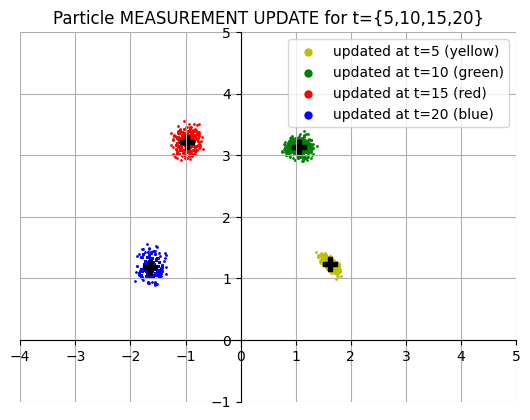

In [16]:
############################################### PART G ####################################################

###########################################################################################################

t1 = 0
t2 = 5
t3 = 10
t4 = 15
t5 = 20

# MEASUREMENTS
z5  = np.array([[1.6561],[1.2847]])
z10 = np.array([[1.0505],[3.1059]])
z15 = np.array([[-0.9875],[3.2118]])
z20 = np.array([[-1.6450],[1.1978]])


#initial particle set X0 consisting of N = 1000 copies of I = (0, I2) ∈ SE(2)
X0=ParticleFilterPropagate(0,np.eye(3),t1,N)

##################### Propagation from t1 = 0 to t2 = 5 ####################################
X5 = ParticleFilterPropagate(t1,X0,t2,N)
X5hat = ParticleFilterUpdate(X5,z5)

#create x data and y data
x5_data,y5_data=dataFROMpose(X5hat)

#Mean and Covariance
mean5, COV5 = stats(x5_data,y5_data,N)
x5_cen, y5_cen = mean5



##################### Propagation from t2 = 5 to t3 = 10 ####################################
X10 =ParticleFilterPropagate(t2,X5,t3,N)
X10hat = ParticleFilterUpdate(X10,z10)

#create x data and y data
x10_data,y10_data=dataFROMpose(X10hat)

#Mean and Covariance
mean10, COV10 = stats(x10_data,y10_data,N)
x10_cen, y10_cen = mean10



##################### Propagation from t3 = 10 to t4 = 15 ####################################
X15 = ParticleFilterPropagate(t3,X10,t4,N)
X15hat = ParticleFilterUpdate(X15,z15)

#create x data and y data
x15_data,y15_data=dataFROMpose(X15hat)

#Mean and Covariance
mean15, COV15 = stats(x15_data,y15_data,N)
x15_cen, y15_cen = mean15

##################### Propagation from t4 = 15 to t5 = 20 ####################################
X20 =ParticleFilterPropagate(t4,X15,t5,N)
X20hat = ParticleFilterUpdate(X20,z20)
#create x data and y data
x20_data,y20_data=dataFROMpose(X20hat)

#Mean and Covariance
mean20, COV20 = stats(x20_data,y20_data,N)
x20_cen, y20_cen = mean20


#plot the position of particle
fig = plt.figure()

# use set_position
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')

plt.xlim(-4, 5)
plt.ylim(-1, 5)
plt.grid(True)

p2=plt.scatter(x5_data,y5_data,s=1,color = 'y')
p1=plt.scatter(x5_cen,y5_cen,s=100,marker='P',color = 'k')

p3=plt.scatter(x10_data,y10_data,s=1,color = 'g')
plt.scatter(x10_cen,y10_cen,s=100,marker='P',color = 'k')

p4=plt.scatter(x15_data,y15_data,s=1,color = 'r')
plt.scatter(x15_cen,y15_cen,s=100,marker='P',color = 'k')

p5=plt.scatter(x20_data,y20_data,s=1,color = 'b')
plt.scatter(x20_cen,y20_cen,s=100,marker='P',color = 'k')

plt.legend([p2,p3,p4,p5], ['updated at t=5 (yellow)','updated at t=10 (green)',
                           'updated at t=15 (red)','updated at t=20 (blue)'], loc=0, numpoints=1,markerscale=5)
plt.title("Particle MEASUREMENT UPDATE for t={5,10,15,20}")

print("For t = 5secs:\nMEAN:",mean5,"\nCOVARIANCE: ",COV5.T)
print("\n\nFor t = 10secs:\nMEAN:",mean10,"\nCOVARIANCE: ",COV10.T)
print("\n\nFor t = 15secs:\nMEAN:",mean15,"\nCOVARIANCE: ",COV15.T)
print("\n\nFor t = 20secs:\nMEAN:",mean20,"\nCOVARIANCE: ",COV20.T)